# Imports and data

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np

# Bianchi period:
start_date = '1971-08-31'
end_date = '2018-12-31'

# start_date = pd.to_datetime('1979-01-01')
# end_date = pd.to_datetime('2024-12-31')

# end_date = '2025-06-30' # kr and gsw end date
maturities = [str(i) for i in range(12, 121) if i % 12 == 0] # select only yearly maturities

yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=maturities) # type can be kr, lw, gsw
forward = bu.get_forward_rates(yields)
xr = bu.get_excess_returns(yields, horizon=12).dropna() # horizon=12 means holding for 12 months
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

monthly_yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=[str(i) for i in range(1, 121)]) # needed for monthly holding period excess returns. Not available for gsw
monthly_xr = bu.get_excess_returns(monthly_yields, horizon=1).dropna() # calculate monthly excess returns for robustness

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)  

# Drop dates outside the xr range
yields = yields.loc[yields.index <= xr.index[-1]]
forward = forward.loc[forward.index <= xr.index[-1]]
xr = xr.loc[xr.index <= xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= xr.index[-1]]
monthly_xr = monthly_xr.loc[monthly_xr.index <= xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

In [3]:
import sklearn
import skglm

class LassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = sklearn.linear_model.Lasso(alpha=self.alpha)
        self.model.fit(X[['yields']], y)
    
    def predict(self, X):
        return self.model.predict(X[['yields']])
    
class RidgeModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = sklearn.linear_model.Ridge(alpha=self.alpha)
        self.model.fit(X[['yields']], y)
    
    def predict(self, X):
        return self.model.predict(X[['yields']])
    
class GroupLassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = skglm.GroupLasso(alpha=self.alpha, groups=[10, 20, 30, 76])
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

# Expanding window estimation

In [ ]:
from models.base import *
from models.classical import *
from models.other import *
from models.ann import *
from models.gbt import *

OOS_start = pd.Timestamp('1990-01-31')

X = pd.concat([fred_md, forward, yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

y = xr['120'].values # 10-year excess returns
# y = monthly_xr['24'].values # 1-month excess returns for robustness
dates = xr.index

# Models to test
models = {
    # 'Lasso': LassoModel(alpha=0.0001),
    # 'Ridge': RidgeModel(alpha=0.0001),
    # 'Linear': LinearModel(),
    'PCA': PCABaselineModel(components=3, series='forward'),
    # 'GroupLasso': GroupLassoModel(alpha=0.01),
    # 'NN': ForwardRateANN(hidden_sizes=[3], do_grid_search=False,
    #                          trainer_kwargs={'epochs': 20, 'lr': 0.01, 'optimizer_type': 'adam', 'patience': 15}),
    # 'RW': RandomWalkModel(),
    # 'Mean': HistoricalMeanModel()
    # 'CP': CochranePiazzesiModel(),
    # 'LN': LudvigsonNgModel(),
    # 'LN_BH': LudvigsonNgBauerHamiltonSpec()
}

results = {}

for name, model in models.items():
    print(f"Running {name}...")
    y_forecast = wu.expanding_window(model, X, y, dates, OOS_start, gap=0) # set gap to 12 for more realistic out-of-sample forecasts
    r2 = wu.oos_r2(y, y_forecast)
    results[name] = {'forecast': y_forecast, 'R2_OOS': r2}
    print(f"  R2_OOS = {r2:.4f}")

# Summary
print("\n--- OOS R² Summary ---")
for name, res in results.items():
    print(f"  {name}: {res['R2_OOS']:.4f}")

Running PCA...


100%|██████████| 336/336 [00:02<00:00, 166.29it/s]

  R2_OOS = 0.0819

--- OOS R² Summary ---
  PCA: 0.0819


<Axes: xlabel='date'>

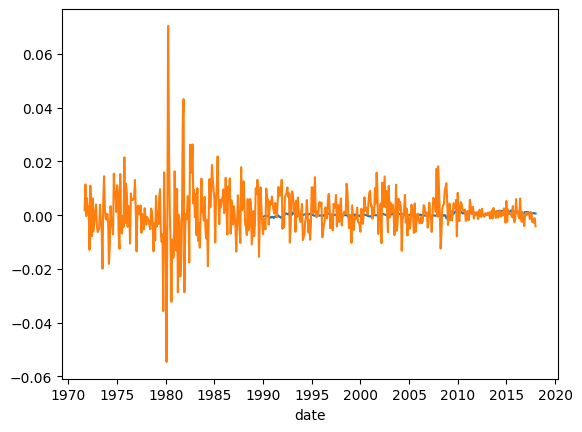

In [13]:
sns.lineplot(y=y_forecast, x=yields.index)
sns.lineplot(y=y, x=yields.index)

# Test in-sample fit

In [22]:
# full-sample R2 for comparison
y = xr['36'].values
model = LudvigsonNgBauerHamiltonSpec()
model.fit(X, y)
r2_full = sklearn.metrics.r2_score(y, model.predict(X))
r2_full

0.3187822502458938

<Axes: xlabel='date'>

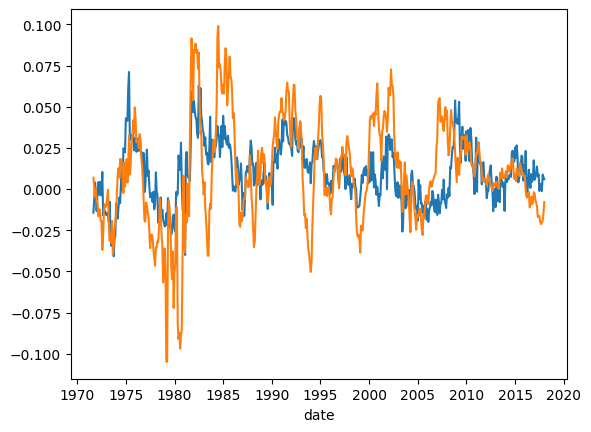

In [23]:
sns.lineplot(y=model.predict(X), x=yields.index)
sns.lineplot(y=y, x=yields.index)